# Demo IV - Comparing Climate Models

In this notebook, I will demonstrate how we can use RBIG to compare climate models using values such as Entropy, Total correlation and Mutual Information.

In [1]:
import os, sys
cwd = os.getcwd()
source_path = f"{cwd}/../"
sys.path.insert(0, f'{source_path}')

# Import RBIG Helper
from src.models.train_models import run_rbig_models

import cdsapi
from zipfile import ZipFile
import pandas as pd
import xarray as xr
from tqdm import tqdm
from sklearn import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Data - Climate Data

You need to have the climate data server api installed. There are some additional instructions that can be found [here](https://cds.climate.copernicus.eu/api-how-to) which involve creating an account as well as agreeing to some terms and conditions.

In [2]:
# set datasave paths
data_path = f"{source_path}data/climate/raw/"
results_path = f"{source_path}data/climate/results/"
fig_path = f"{source_path}reports/figures/climate/"
file_name = "it_sst.zip"
# initialize client

c = cdsapi.Client()

**Datasets**

We will be taking the CIMP5 monthly projections for sea surface temperature. We will look at the following models:

* GISS E2 H
* GISS E2 H CC
* GISS E2 R
* GISS E2 R CC

In [5]:
c.retrieve(
    'projections-cmip5-monthly-single-levels',
    {
        'variable':'sea_surface_temperature',
        'model':[
            'giss_e2_h','giss_e2_h_cc','giss_e2_r',
            'giss_e2_r_cc'
        ],
        'experiment':'rcp_8_5',
        'ensemble_member':'r1i1p1',
        'period':[
            '200601-202512','200601-205012'
        ],
        'format':'netcdf'
    },
    f"{data_path}{file_name}", )

Result(content_length=37296357,content_type=application/zip,location=http://136.156.132.153/cache-compute-0002/cache/data6/dataset-projections-cmip5-monthly-single-levels-fcfdbaab-20c2-4081-961f-b07f22771fc5.zip)

In [13]:
# unzip file in same directory
with ZipFile(f'{data_path}{file_name}', 'r') as zipObj:
    zipObj.extractall(path=f"{data_path}")

In [3]:
# read in climate Models
clim_model1_50 = xr.open_dataset(f"{data_path}tos_Omon_GISS-E2-H-CC_rcp85_r1i1p1_200601-205012.nc")
clim_model2_50 = xr.open_dataset(f"{data_path}tos_Omon_GISS-E2-H_rcp85_r1i1p1_200601-205012.nc")
clim_model1_25 = xr.open_dataset(f"{data_path}tos_Omon_GISS-E2-R-CC_rcp85_r1i1p1_200601-202512.nc")
clim_model2_25 = xr.open_dataset(f"{data_path}tos_Omon_GISS-E2-R_rcp85_r1i1p1_200601-202512.nc")

clim_model1_50

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 90, lon: 144, time: 540)
Coordinates:
  * time       (time) object 2006-01-16 12:00:00 ... 2050-12-16 12:00:00
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tos        (time, lat, lon) float32 ...
Attributes:
    institution:            NASA/GISS (Goddard Institute for Space Studies) N...
    institute_id:           NASA-GISS
    experiment_id:          rcp85
    source:                 GISS-E2-H-CC-E4arobio_h8RCP85 Atmosphere: GISS-E2...
    model_id:               GISS-E2-H-CC
    forcing:                GHG, LU, Sl, Vl, BC, OC, SA, Oz (also includes BC...
    parent_experiment_id:   historical
    parent_experiment_rip:  r1i1p1
    branch_time:            2006

In [26]:
def normalize(X):
    X_mean, X_std = X.groupby('time').mean(), X.groupby('time').std(axis=0)
    return (X - X_mean) / X_std

## Experiment I - Climate Models Decade 2025

In [57]:
# Experiment class
class ClimateEntropy:
    def __init__(self, save_path: None):
        
        self.results_path = save_path
        self.results_df = pd.DataFrame()
    
    def run_experiment(self, climate_model1: pd.DataFrame, climate_model2: pd.DataFrame) -> None:
        """Training loop that goes through each year and calculates the entropy,
        total correlation and mutual information between the two models."""
        time_length = len(climate_model1.groupby('time.year'))
        
        # Normalize BEFORE the individual calculations
        climate_model1['tos'] = normalize(climate_model1['tos'])
        climate_model2['tos'] = normalize(climate_model2['tos'])
        
        with tqdm(zip(
            climate_model1.groupby('time.year'), 
            climate_model2.groupby('time.year')
        ), total=time_length) as progress_bar:
            
            for imodel1, imodel2 in progress_bar:
                
                # Update params in progress bar
                
                # Transform to dataframe, remove spatial dimensions
                X1 = self._get_time_features(imodel1[1]['tos'])
                X2 = self._get_time_features(imodel2[1]['tos'])
                
                # Normalize inputs
                min_max_scaler = preprocessing.StandardScaler()
                X1 = min_max_scaler.fit_transform(X1.values)
                X2 = min_max_scaler.fit_transform(X2.values)
                
                dims = X1.shape[1]
                
                # =============================
                # Calculate Mutual Information
                # =============================
                mi_, mi_t_ = run_rbig_models(X1, X2, measure='mi', verbose=None)
                
                
                # Update params in progress bar
                postfix = dict(
                    
                )

                # ========================================
                # Calculate Entropy and Total Correlation
                # ========================================
                
                # Model I
                tc1_, h1_, h_t1_ = run_rbig_models(X1, measure='t', verbose=None)
                
                self._update_results(
                    model=imodel1[1].attrs['model_id'],
                    year=imodel1[0],
                    h_time=h_t1_,
                    tc=tc1_,
                    h=h1_,
                    mi=mi_,
                    mi_time=mi_t_,
                    dims=dims,
                    
                )
                
                
                # Model II
                tc2_, h2_, h_t2_ = run_rbig_models(X2, measure='t', verbose=None)
                self._update_results(
                    model=imodel2[1].attrs['model_id'],
                    year=imodel2[0],
                    h_time=h_t2_,
                    tc=tc2_,
                    h=h2_,
                    mi=mi_,
                    mi_time=mi_t_,
                    dims=dims,
                    
                )
                
                # Update params in progress bar
                postfix = dict(
                    year=imodel1[0],
                    mi=f"{mi_:.3f}",
                    h1=f"{h1_:.3f}",
                    tc1=f"{tc1_:.3f}",
                    h2=f"{h2_:.3f}",
                    tc2=f"{tc2_:.3f}",
                )
                

                
                progress_bar.set_postfix(postfix)
            
        
        return None
    
    def _get_time_features(self, data_df: pd.DataFrame)-> pd.DataFrame:
        """This function collapses the spatial dimensions as pivots. This allows
        us to only consider time as the input feature."""
        return data_df.to_dataframe().unstack(level=0).reset_index().drop(columns=['lat', 'lon']).dropna()
    
    def _update_results(self, model, year, tc, h, h_time, mi, mi_time, dims):
        """appends new values to the results dataframe."""
        self.results_df = self.results_df.append({
            'model': model,
            'year': year,
            'tc': tc,
            'h': h,
            'h_time': h_time,
            'mi': mi,
            'mi_time': mi_time,
            'dims': dims,
        }, ignore_index=True
        )
        
        if self.results_path is not None:
            self._save_results()
        return self
    
    def _save_results(self):
        """Saves the dataframe to the assigned results path."""
        self.results_df.to_csv(self.results_path)
        return None

In [58]:
# Initialize experiment
short_decade_exp = ClimateEntropy(f"{results_path}demo_climate_y25.csv")

# run experiment (shorter decade)
short_decade_exp.run_experiment(clim_model1_25, clim_model2_25)

100%|██████████| 20/20 [30:34<00:00, 91.71s/it, year=2025, mi=2.802, h1=-19.522, tc1=31.399, h2=-19.191, tc2=30.954]


In [78]:
# extract results
results_df = short_decade_exp.results_df

In [79]:
# remove outlier year with huge spike...
results_df = results_df[results_df['year'] != 2012]

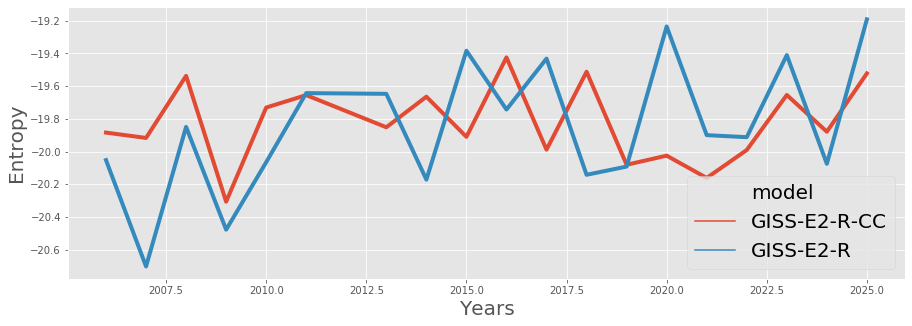

In [85]:
# plot the entropy
fig, ax = plt.subplots( figsize=(15, 5))

sns.lineplot(ax=ax, x='year', y='h', hue='model', data=results_df, linewidth=4,)
# sns.lineplot(ax=ax, x='nm_features', y='I', data=ndvi_df, label=label_main, linewidth=4,)
ax.set_xlabel('Years', fontsize=20)
ax.set_ylabel('Entropy', fontsize=20)
# ax.set_ylim([34, 38])
plt.legend(fontsize=20)
plt.show()
fig.savefig(f"{fig_path}climate_m25_h.png")

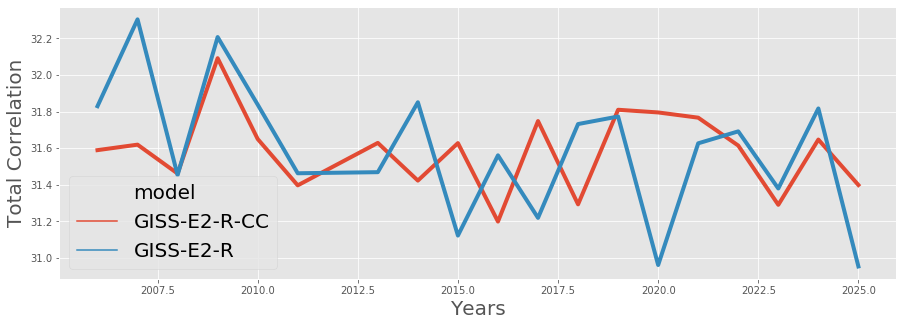

In [86]:
# plot the entropy
fig, ax = plt.subplots( figsize=(15, 5))

sns.lineplot(ax=ax, x='year', y='tc', hue='model', data=results_df, linewidth=4,)
# sns.lineplot(ax=ax, x='nm_features', y='I', data=ndvi_df, label=label_main, linewidth=4,)
ax.set_xlabel('Years', fontsize=20)
ax.set_ylabel('Total Correlation', fontsize=20)
plt.legend(fontsize=20)
plt.show()
fig.savefig(f"{fig_path}climate_m25_tc.png")

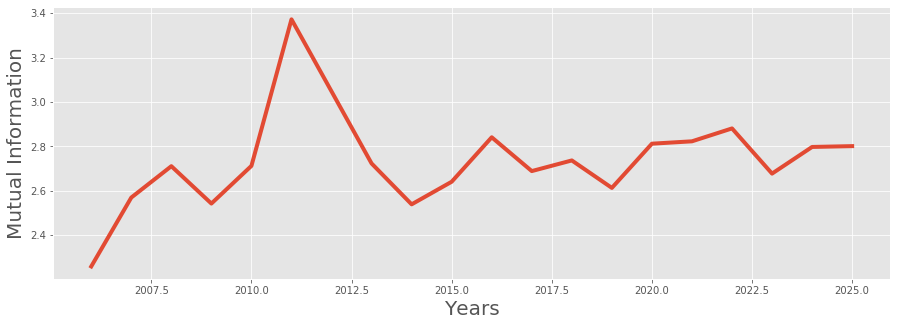

In [87]:
# plot the mutual information
fig, ax = plt.subplots( figsize=(15, 5))

sns.lineplot(ax=ax, x='year', y='mi', data=results_df, linewidth=4,)
# sns.lineplot(ax=ax, x='nm_features', y='I', data=ndvi_df, label=label_main, linewidth=4,)
ax.set_xlabel('Years', fontsize=20)
ax.set_ylabel('Mutual Information', fontsize=20)
# plt.legend(fontsize=20)
plt.show()
fig.savefig(f"{fig_path}climate_m25_mi.png")

## Experiment II - Climate Models Decade 2050

In [49]:
# Initialize experiment
long_decade_exp = ClimateEntropy(f"{results_path}demo_climate_y50.csv")

# run experiment (shorter decade)
long_decade_exp.run_experiment(clim_model1_50, clim_model2_50)

100%|██████████| 45/45 [1:12:19<00:00, 96.42s/it, year=2050, mi=2.007, h1=-21.115, tc1=32.792, h2=-21.191, tc2=33.532]


### Visualization

We will do a simple plot where we look at the year versus the amount of entropy (per year).

In [ ]:
# some matplotib default params to make the plots look presentable

mpl.rc(
    'lines', linewidth=4,
)
mpl.rc('xtick', labelsize=30,)
mpl.rc('ytick', labelsize=30)
mpl.rc({'font.size': 30})
# mpl.rc({'axes.labelsize': 20})
mpl.rc('axes', labelsize=30)
mpl.rc('legend', fontsize=20, framealpha=0.4)

In [50]:
# extract results
results_df = short_decade_exp.results_df


In [56]:
results_df.head()

,dims,h,h_time,mi,mi_time,model,tc,year
0,12.0,32.936931,-21.870854,2.337452,105.546760,GISS-E2-H-CC,7.808090,2006.0
1,12.0,33.388721,-21.365233,2.337452,105.546760,GISS-E2-H,8.584583,2006.0
2,12.0,32.561952,-21.429492,2.416123,59.601510,GISS-E2-H-CC,12.076586,2007.0
3,12.0,33.382210,-21.360064,2.416123,59.601510,GISS-E2-H,8.930050,2007.0
4,12.0,32.585305,-21.571000,2.184509,60.191658,GISS-E2-H-CC,10.183939,2008.0


In [55]:
results_df.to_csv(f"{results_path}demo_climate_y50.csv")

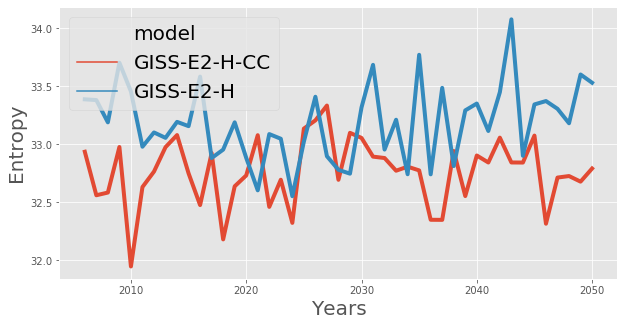

In [52]:
# plot the entropy
fig, ax = plt.subplots( figsize=(10, 5))

sns.lineplot(ax=ax, x='year', y='h', hue='model', data=results_df, linewidth=4,)
# sns.lineplot(ax=ax, x='nm_features', y='I', data=ndvi_df, label=label_main, linewidth=4,)
ax.set_xlabel('Years', fontsize=20)
ax.set_ylabel('Entropy', fontsize=20)
# ax.set_ylim([34, 38])
plt.legend(fontsize=20)
plt.show()
fig.savefig(f"{fig_path}climate_m50_h.png")

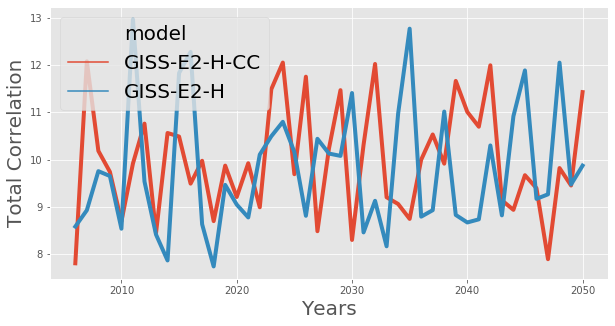

In [53]:
# plot the entropy
fig, ax = plt.subplots( figsize=(10, 5))

sns.lineplot(ax=ax, x='year', y='tc', hue='model', data=results_df, linewidth=4,)
# sns.lineplot(ax=ax, x='nm_features', y='I', data=ndvi_df, label=label_main, linewidth=4,)
ax.set_xlabel('Years', fontsize=20)
ax.set_ylabel('Total Correlation', fontsize=20)
plt.legend(fontsize=20)
plt.show()
fig.savefig(f"{fig_path}climate_m50_tc.png")

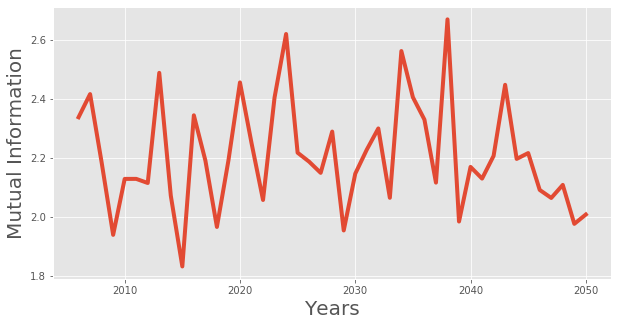

In [54]:
# plot the mutual information
fig, ax = plt.subplots( figsize=(10, 5))

sns.lineplot(ax=ax, x='year', y='mi', data=results_df, linewidth=4,)
# sns.lineplot(ax=ax, x='nm_features', y='I', data=ndvi_df, label=label_main, linewidth=4,)
ax.set_xlabel('Years', fontsize=20)
ax.set_ylabel('Mutual Information', fontsize=20)
# plt.legend(fontsize=20)
plt.show()
fig.savefig(f"{fig_path}climate_m50_mi.png")